# koan_2 — Linear regression

The purpose of this koan is to solve a simple optimization problem.

In particular, we'll set up some pairs of data points $(x, y)$ where

$$y \approx Ax,$$

with $x, y$ being column vectors, and $A$ being a matrix.

Given these noisy data points, our goal will be to reconstruct
the matrix $A$, treating this as a numeric optimization problem.

## Imports

In [1]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

## Create our noisy data points

In [2]:
# Set up the matrix A.
torch.manual_seed(42)
A = torch.rand(5, 5)

In [3]:
A

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317, 0.1053]])

In [4]:
# Create 500 data points.
n     = 1_000
all_x = 10 * torch.rand(n, 5)
eps   =  2 * torch.randn(n, 5)
all_y = (A @ all_x.T + eps.T).T

In [5]:
# Sanity check.
all_y.shape

torch.Size([1000, 5])

In [6]:
# Set up a DataLoader with this data.
dataset = TensorDataset(all_x, all_y)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

## Set up the model

This is a simple model capturing the relationship $y=Ax$.

In [7]:
class LinRegModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        return self.linear(x)

In [8]:
model = LinRegModel(5, 5)

## Train the model

In [9]:
# Set things up pre-training.

loss_fn    = nn.MSELoss()
opt        = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

In [10]:
# Train.
# This is slightly slowed down so you can see the numbers evolve.

losses = []
A_diffs = []

for epoch in range(num_epochs):
    for x, y in dataloader:
        
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()
    
    A_diff = torch.norm(A - model.linear.weight.data)
    print(f'\rEpoch {epoch + 1:2d}/{num_epochs}. Loss {loss.item():6.3f} A_diff {A_diff:7.5f}', end='', flush=True)
    losses.append(loss.item())
    A_diffs.append(A_diff)
    
    time.sleep(0.05)

Epoch 100/100. Loss  3.851 A_diff 0.08257

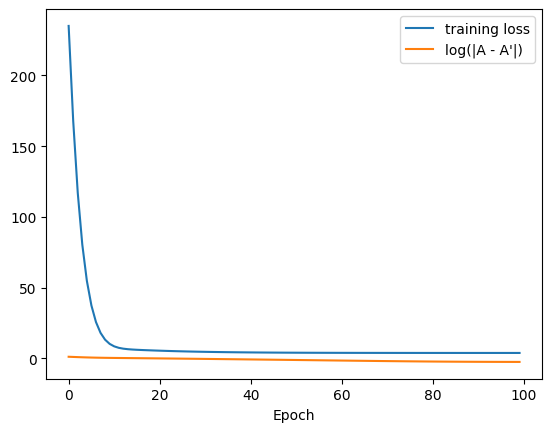

In [11]:
# Plot the trajectory of loss values and A diffs.

plt.plot(losses, label='training loss')
plt.plot(torch.log(torch.tensor(A_diffs)), label='log(|A - A\'|)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
print('Actual matrix A:\n', A)

Actual matrix A:
 tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317, 0.1053]])


In [13]:
print('Approximated matrix A\':\n', model.linear.weight.data)

Approximated matrix A':
 tensor([[0.8776, 0.8931, 0.4134, 0.9405, 0.4135],
        [0.6002, 0.2591, 0.7685, 0.9407, 0.1466],
        [0.9320, 0.5983, 0.8651, 0.5636, 0.7500],
        [0.4560, 0.8692, 0.5468, 0.2622, 0.6505],
        [0.2678, 0.4658, 0.2797, 0.8485, 0.0951]])
